# DATA_ENG 300 HW 2

## Part 1 (Relational)

In [1]:
!pip install duckdb==1.2.2
import duckdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 54.2 MB/s eta 0:00:00:00:010:01


In [2]:
# establish connection
conn = duckdb.connect(database='healthcare_hw2.db', read_only=False)
base_path = 'C:\\Users\\nkim0\\OneDrive - Northwestern University\\NU Classes\\DATA_ENG 300\\Homework 2'

tables = [
    'ADMISSIONS',
    'ICUSTAYS',
    'PATIENTS',
    'PROCEDURES_ICD',
    'D_ICD_PROCEDURES',
    'DRGCODES',
    'PRESCRIPTIONS'
]

# load each CSV into DuckDB
for table_name in tables:
    file_name = f'{table_name}.csv'
    conn.execute(f"""
        CREATE OR REPLACE TABLE {table_name} AS
        SELECT * FROM read_csv_auto('{file_name}')
    """)

### Question 1

In [3]:
# query
conn.sql(
    """
    SELECT ethnicity, drug, drug_occurences
    FROM (
        SELECT 
            a.ethnicity, 
            p.drug, 
            COUNT(*) AS drug_occurences,
            ROW_NUMBER() OVER (PARTITION BY a.ethnicity ORDER BY COUNT(*) DESC) AS rank
        FROM PRESCRIPTIONS p
        JOIN ADMISSIONS a ON p.hadm_id = a.hadm_id
        GROUP BY a.ethnicity, p.drug
    ) sub
    WHERE rank = 1
    ORDER BY ethnicity;

    """
)

┌──────────────────────────────────────────────────────────┬──────────────────────┬─────────────────┐
│                        ethnicity                         │         drug         │ drug_occurences │
│                         varchar                          │       varchar        │      int64      │
├──────────────────────────────────────────────────────────┼──────────────────────┼─────────────────┤
│ AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE │ 5% Dextrose          │              27 │
│ ASIAN                                                    │ D5W                  │              27 │
│ BLACK/AFRICAN AMERICAN                                   │ Insulin              │              38 │
│ HISPANIC OR LATINO                                       │ 5% Dextrose          │              28 │
│ HISPANIC/LATINO - PUERTO RICAN                           │ 0.9% Sodium Chloride │              86 │
│ OTHER                                                    │ NS                   

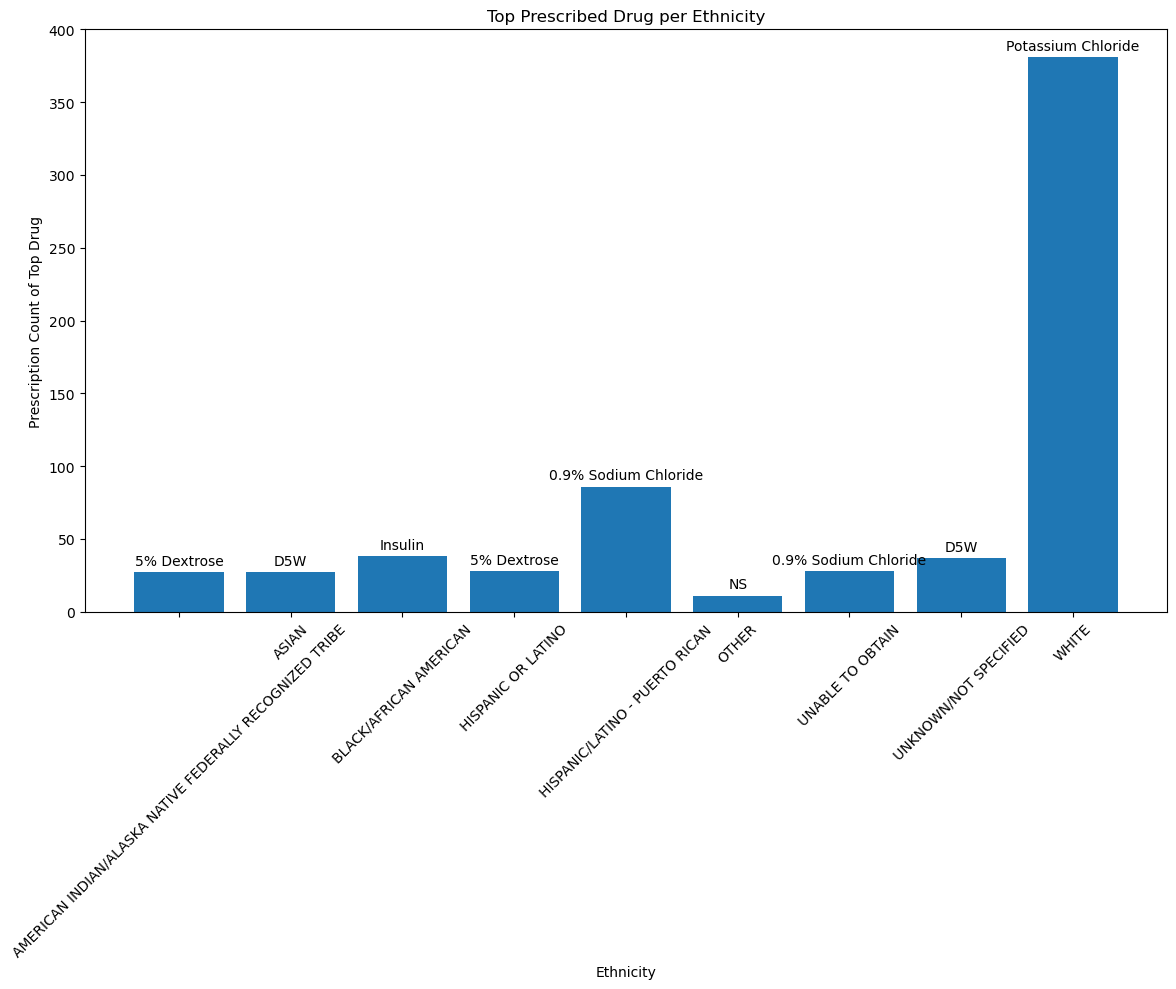

In [5]:
# plot results
import matplotlib.pyplot as plt

df_drug_occurences = conn.sql(
    """
    SELECT ethnicity, drug, drug_occurences
    FROM (
        SELECT 
            a.ethnicity, 
            p.drug, 
            COUNT(*) AS drug_occurences,
            ROW_NUMBER() OVER (PARTITION BY a.ethnicity ORDER BY COUNT(*) DESC) AS rank
        FROM PRESCRIPTIONS p
        JOIN ADMISSIONS a ON p.hadm_id = a.hadm_id
        GROUP BY a.ethnicity, p.drug
    ) sub
    WHERE rank = 1
    ORDER BY ethnicity;

    """
).df()

plt.figure(figsize=(12, 10))
bars = plt.bar(df_drug_occurences['ethnicity'], df_drug_occurences['drug_occurences'])
plt.xlabel('Ethnicity')
plt.ylabel('Prescription Count of Top Drug')
plt.title('Top Prescribed Drug per Ethnicity')
plt.xticks(rotation=45)
for bar, drug in zip(bars, df_drug_occurences['drug']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5, drug, ha='center', fontsize=10)
plt.tight_layout()
plt.show()

***Query Explanation***

In my query, I joined the PRESCRIPTIONS and ADMISSIONS tables to obtain information on the ethnicity of the individual of each prescription. I joined on HADM_ID because I wanted to obtain information based on admission-level data. From here I counted the number of times each drug was prescribed for each ethnicity and gave rankings of the drugs within each ethnicity based on the number of occurrences for each drug. Finally, I filtered the query to only show the results with rank 1 and ordered the results alphabetically by ethnicity.

***Summary of Findings***

I found that top used drug is Potassium Chloride for Whites, 5% Dextrose for American Indian/Alaska Native Federally Recognized Tribes and Hispanic/Latino, D5W for Asians, Insulin for Black/African American, and 0.9% Sodium Chloride for Hispanic/Latino-Puerto Rican. Some other commonly used drugs for unspecified individuals are 0.9% Sodium Chloride and D5W. The total counts for the usage of the respective top drug for each ethnicity was greatest for White with a count of 381 and lowest for American Indian/Alaska Native Federally Recognized Tribes and Asians with a count of 27, excluding the individuals with unknown ethnicities.


### Question 2

In [9]:
conn.sql(
    """
    WITH ranked_procedures AS (
        SELECT
            CASE
                WHEN age <= 19 THEN '0-19'
                WHEN age BETWEEN 20 AND 49 THEN '20-49'
                WHEN age BETWEEN 50 AND 79 THEN '50-79'
                ELSE '80+'
            END AS age_group,
            d.short_title AS procedure_name,
            COUNT(*) AS procedure_count,
            ROW_NUMBER() OVER (
                PARTITION BY
                    CASE
                        WHEN age <= 19 THEN '0-19'
                        WHEN age BETWEEN 20 AND 49 THEN '20-49'
                        WHEN age BETWEEN 50 AND 79 THEN '50-79'
                        ELSE '80+'
                    END
                ORDER BY COUNT(*) DESC
            ) AS rank_in_group
        FROM (
            SELECT
                p.subject_id, p.hadm_id, p.icd9_code, p.seq_num,
                DATEDIFF('year', pat.dob, a.admittime) AS age
            FROM PROCEDURES_ICD p
            JOIN ADMISSIONS a ON p.hadm_id = a.hadm_id
            JOIN PATIENTS pat ON p.subject_id = pat.subject_id
        ) AS procedures_with_age
        JOIN D_ICD_PROCEDURES d
        ON procedures_with_age.icd9_code = d.icd9_code
        GROUP BY age_group, procedure_name
    )
    SELECT age_group, procedure_name, procedure_count
    FROM ranked_procedures
    WHERE rank_in_group <= 3
    ORDER BY age_group, rank_in_group;
    """
)

┌───────────┬──────────────────────────┬─────────────────┐
│ age_group │      procedure_name      │ procedure_count │
│  varchar  │         varchar          │      int64      │
├───────────┼──────────────────────────┼─────────────────┤
│ 0-19      │ Venous cath NEC          │               2 │
│ 0-19      │ Vertebral fx repair      │               1 │
│ 0-19      │ Interruption vena cava   │               1 │
│ 20-49     │ Venous cath NEC          │               9 │
│ 20-49     │ Entral infus nutrit sub  │               7 │
│ 20-49     │ Insert endotracheal tube │               6 │
│ 50-79     │ Venous cath NEC          │              25 │
│ 50-79     │ Entral infus nutrit sub  │              22 │
│ 50-79     │ Packed cell transfusion  │              13 │
│ 80+       │ Venous cath NEC          │              20 │
│ 80+       │ Packed cell transfusion  │              13 │
│ 80+       │ Insert endotracheal tube │               8 │
├───────────┴──────────────────────────┴────────────────

***Query Explanation***

In my query, I joined the PROCEDURES_ICD table with the ADMISSIONS and PATIENTS table on the icd9_code, subject_id, or hadm_code to pull all the necessary information. To calculate the age of each patient at the time of their admission to the hospital I used the difference between their date of birth and the admission date. From the joined tables, the information I selected to show were the age groups, procedure, and count of procedures for that age group. To create the age groups, I used a CASE statement to classify the patients into the four age groups of <=19, 20-49, 50-79, and >80. From here, I grouped the data by the age group and procedure name and then ordered the data by age group and procedure count in descending order. I also ranked all the rows of data within each age group and only returned the top three for each group.

***Summary of Findings***

The above table summarizes my findings on the top three procedures for each age group along with the count. For the age group from 0 to 19, the top three procedures are Venous cath NEC, Vertebral fx repair, Interruption vena cava. For the age group from 20 to 49, the top three procedures are Venous cath NEC, Enthral infus nutrit sub, and Cont inv mec ven 96+ hrs. For the age group from 50-70, the top three procedures are Venous cath NEC, Entral infus nutrit sub, and packed cell transfusion. For the 80+ age group, the top three procedures are Venous cath NEC, packed cell transfution, and insert endotracheal tube.

We can see that venous cath NEC is the top procedure for all four age groups. Entral infus nutrit sub is the second top procedure for the 20-49 and 50-79 age groups and Packed cell transfusion is one of the top three procedures for the 50-79 and 80+ age groups. The other top procedures varied across the age groups.

### Question 3

In [10]:
# query
conn.sql(
    """
    SELECT
        a.ethnicity,
        p.gender,
        AVG(i.los) AS avg_los,
    FROM ICUSTAYS i
    JOIN ADMISSIONS a ON i.hadm_id = a.hadm_id
    JOIN PATIENTS p ON i.subject_id = p.subject_id
    WHERE i.los IS NOT NULL
    GROUP BY a.ethnicity, p.gender
    ORDER BY a.ethnicity, p.gender;
    """
)

┌──────────────────────────────────────────────────────────┬─────────┬────────────────────┐
│                        ethnicity                         │ gender  │      avg_los       │
│                         varchar                          │ varchar │       double       │
├──────────────────────────────────────────────────────────┼─────────┼────────────────────┤
│ AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE │ M       │           11.33715 │
│ ASIAN                                                    │ F       │             0.6628 │
│ ASIAN                                                    │ M       │             7.1173 │
│ BLACK/AFRICAN AMERICAN                                   │ F       │          11.201225 │
│ BLACK/AFRICAN AMERICAN                                   │ M       │ 2.9772666666666665 │
│ HISPANIC OR LATINO                                       │ F       │  7.459633333333334 │
│ HISPANIC/LATINO - PUERTO RICAN                           │ M       │ 3.2430666

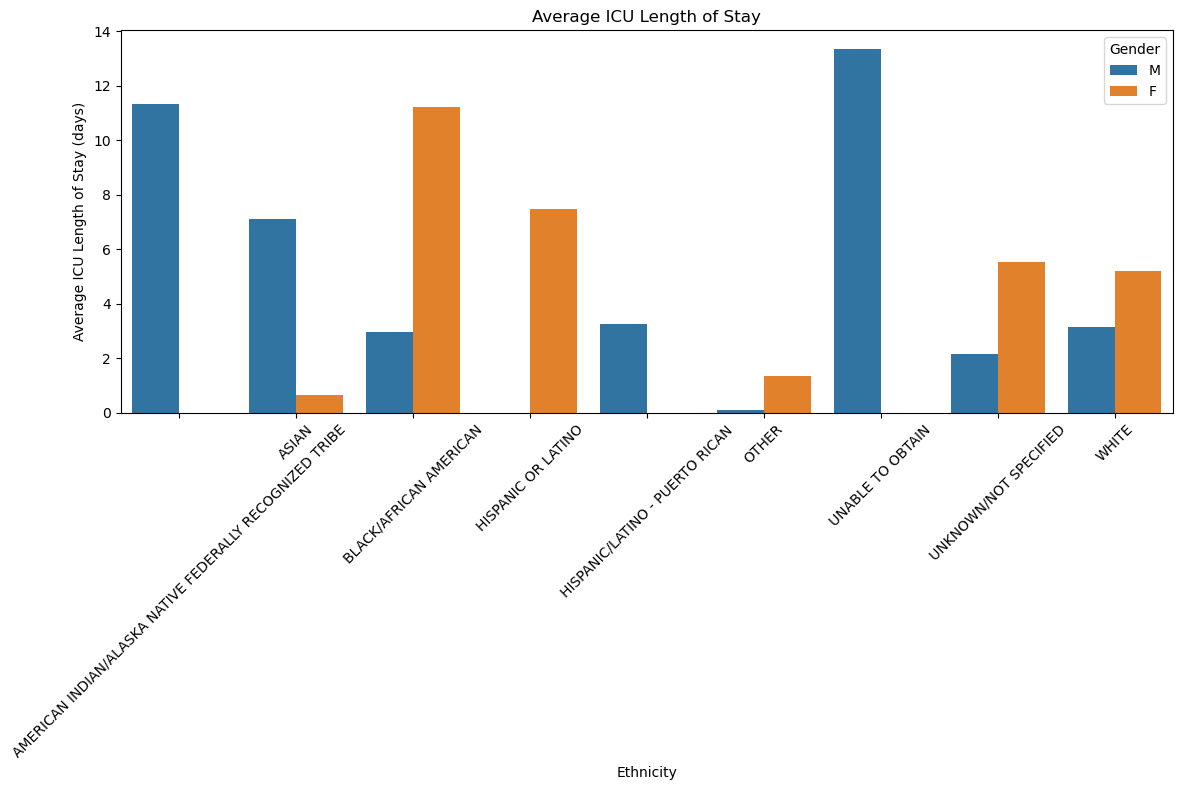

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# save result as dataframe
df_los = conn.sql(
    """
    SELECT
        a.ethnicity,
        p.gender,
        AVG(i.los) AS avg_los,
    FROM ICUSTAYS i
    JOIN ADMISSIONS a ON i.hadm_id = a.hadm_id
    JOIN PATIENTS p ON i.subject_id = p.subject_id
    WHERE i.los IS NOT NULL
    GROUP BY a.ethnicity, p.gender
    ORDER BY a.ethnicity, p.gender;
    """
).df()

# plot
plt.figure(figsize=(12, 8))
sns.barplot(data=df_los, x='ethnicity', y='avg_los', hue='gender')
plt.title('Average ICU Length of Stay')
plt.xlabel('Ethnicity')
plt.ylabel('Average ICU Length of Stay (days)')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()


***Query Explanation***

In my query, I joined the ICUSTAYS and ADMISSIONS tables through hadm_id then joined ICUSTAYS with PATIENTS through subject_id. From here, I was able to select the ethnicity, gender, and length of stay information. Because I needed to aggregate the length of stay (los) information, I decided to show the average length of stay for each ethnicity and gender groups. From here, I ordered the data by ethnicity then by gender.


***Summary of Findings***

The group with the highest average length of stay was male American Indian/Alaska native federally recognized tribes of around 11.33 days followed by female Black/African Americans (11.20 days) and female Hispanic/Latino (7.46 days). Overall, there is a pretty significant difference in the average length of stay across ethnicities and genders.

## Part 2 (Non-relational)

### Question 1

In [5]:
!curl https://certs.secureserver.net/repository/sf-class2-root.crt -O

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1468  100  1468    0     0   6002      0 --:--:-- --:--:-- --:--:--  5991


In [6]:
%pip install cassandra-sigv4
%pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 63.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 75.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 7.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [7]:
from cassandra.cluster import Cluster
from ssl import SSLContext, PROTOCOL_TLSv1_2, CERT_REQUIRED
from cassandra_sigv4.auth import SigV4AuthProvider
import boto3

# ssl setup
ssl_context = SSLContext(PROTOCOL_TLSv1_2)
ssl_context.load_verify_locations('sf-class2-root.crt')  # change your file path for locating the certificate
ssl_context.verify_mode = CERT_REQUIRED

# boto3 session setup
boto_session = boto3.Session(region_name="us-east-2")  # this AWS credentials is specific to `us-east-2` region

/tmp/ipykernel_132/332746716.py:7: DeprecationWarning: ssl.PROTOCOL_TLSv1_2 is deprecated
  ssl_context = SSLContext(PROTOCOL_TLSv1_2)


In [8]:
# authorization setup with SigV4
auth_provider = SigV4AuthProvider(boto_session)

In [9]:
#cluster setup 
cluster = Cluster(['cassandra.us-east-2.amazonaws.com'], 
                  ssl_context=ssl_context, 
                  auth_provider=auth_provider, 
                  port=9142) 

In [10]:
session = cluster.connect()

In [11]:
# create a keyspace
r = session.execute('''
    CREATE KEYSPACE IF NOT EXISTS de300_hw2_nkim 
    WITH replication = {'class': 'SingleRegionStrategy'};
    ''')
print(r.current_rows)

[]


In [12]:
from cassandra.cluster import ExecutionProfile, EXEC_PROFILE_DEFAULT
from cassandra import ConsistencyLevel


# Define execution profile with LOCAL_QUORUM
execution_profile = ExecutionProfile(
    consistency_level=ConsistencyLevel.LOCAL_QUORUM
)

# Cluster setup with correct profile
cluster = Cluster(
    ['cassandra.us-east-2.amazonaws.com'],
    ssl_context=ssl_context,
    auth_provider=auth_provider,
    port=9142,
    execution_profiles={EXEC_PROFILE_DEFAULT: execution_profile}
)

# establishing connection to Keyspace
session = cluster.connect()
session.set_keyspace('de300_hw2_nkim') 

## Question 1

In [13]:
session.execute("DROP TABLE IF EXISTS drug_usage_by_ethnicity")

In [14]:
# create table
session.execute("""
CREATE TABLE IF NOT EXISTS drug_occurrences_by_ethnicity (
    ethnicity TEXT,
    total_count INT,
    drug TEXT,
    PRIMARY KEY (ethnicity, total_count, drug)
) WITH CLUSTERING ORDER BY (total_count DESC)
""")

In [16]:
# upload data
import csv
from cassandra.cluster import Cluster, ExecutionProfile, EXEC_PROFILE_DEFAULT
from cassandra import ConsistencyLevel

indiv_ethnicity = {}
with open('ADMISSIONS.csv', newline='') as f_admissions:
    reader = csv.DictReader(f_admissions)
    for row in reader:
        subject_id = row['subject_id']
        ethnicity = row['ethnicity']
        indiv_ethnicity[subject_id] = ethnicity

drug_occurences = {}
with open('PRESCRIPTIONS.csv', newline='') as f_prescriptions:
    reader = csv.DictReader(f_prescriptions)
    processed = 0
    for row in reader:
        subject_id = row['subject_id']
        drug = row['drug']
        ethnicity = indiv_ethnicity.get(subject_id, 'UNKNOWN')
        key = (ethnicity, drug)
        if key not in drug_occurences:
            drug_occurences[key] = 0
        drug_occurences[key] += 1
        processed += 1

In [17]:
# insert data to table
for (ethnicity, drug), total_count in drug_occurences.items():
    session.execute("""
        INSERT INTO drug_occurrences_by_ethnicity (ethnicity, total_count, drug)
        VALUES (%s, %s, %s)
    """, (ethnicity, total_count, drug))

In [18]:
# export table as csv
rows = session.execute("SELECT * FROM drug_occurrences_by_ethnicity")
with open("drug_occurrences_by_ethnicity_output.csv", "w", newline='') as f_out:
    writer = csv.writer(f_out)
    writer.writerow(["ethnicity", "total_count", "drug"])
    count = 0
    for row in rows:
        writer.writerow([row.ethnicity, row.total_count, row.drug])
        count += 1

In [20]:
# post-extraction analysis: obtain top drug used by each ethnicity
from collections import defaultdict

data = []
with open("drug_occurrences_by_ethnicity_output.csv", newline='') as f_in:
    reader = csv.DictReader(f_in)
    for row in reader:
        data.append({
            'ethnicity': row['ethnicity'],
            'drug': row['drug'],
            'total_count': int(row['total_count'])
        })

ethnicity_grouped = defaultdict(list)
for record in data:
    ethnicity_grouped[record['ethnicity']].append(record)

top_drug_per_ethnicity = {}
for ethnicity, records in ethnicity_grouped.items():
    top_drug = max(records, key=lambda x: x['total_count'])
    top_drug_per_ethnicity[ethnicity] = top_drug

with open("top_drug_per_ethnicity.csv", "w", newline='') as f_out:
    writer = csv.writer(f_out)
    writer.writerow(["ethnicity", "drug", "total_count"])
    for ethnicity, top_drug in top_drug_per_ethnicity.items():
        writer.writerow([ethnicity, top_drug['drug'], top_drug['total_count']])

In [14]:
# verify extraction
import pandas as pd
pd.read_csv("top_drug_per_ethnicity.csv")

,ethnicity,drug,total_count
0,OTHER,NS,11
1,BLACK/AFRICAN AMERICAN,Insulin,38
2,WHITE,Potassium Chloride,381
3,ASIAN,D5W,27
4,HISPANIC/LATINO - PUERTO RICAN,0.9% Sodium Chloride,86
5,UNKNOWN/NOT SPECIFIED,D5W,37
6,UNABLE TO OBTAIN,0.9% Sodium Chloride,28
7,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,5% Dextrose,27
8,HISPANIC OR LATINO,5% Dextrose,28


## Question 2

In [24]:
session.execute("DROP TABLE IF EXISTS top_procedures_by_agegroup")

In [25]:
session.execute("""
CREATE TABLE IF NOT EXISTS top_procedure_by_age (
    age_group TEXT,
    procedure_count INT,
    procedure TEXT,
    PRIMARY KEY (age_group, procedure_count, procedure)
) WITH CLUSTERING ORDER BY (procedure_count DESC)
""")

In [27]:
# open csv files
from datetime import datetime

# patients csv 
dob_map = {}
with open('PATIENTS.csv', newline='') as f_patients:
    reader = csv.DictReader(f_patients)
    for row in reader:
        dob_map[row['subject_id']] = row['dob']
        
# admissions csv
ages = {}
with open('ADMISSIONS.csv', newline='') as f_admissions:
    reader = csv.DictReader(f_admissions)
    for row in reader:
        subject_id = row['subject_id']
        hadm_id = row['hadm_id']
        admittime = row['admittime']
        dob = dob_map.get(subject_id)
        if dob:
            age = datetime.strptime(admittime, '%Y-%m-%d %H:%M:%S').year - datetime.strptime(dob, '%Y-%m-%d %H:%M:%S').year
            ages[(subject_id, hadm_id)] = age

# d_icd_procedures csv
procedure_names = {}
with open('D_ICD_PROCEDURES.csv', newline='') as f_procs:
    reader = csv.DictReader(f_procs)
    for row in reader:
        procedure_names[row['icd9_code']] = row['short_title']

# procedures_icd csv & make age groups
procedure_counts = {}

with open('PROCEDURES_ICD.csv', newline='') as f_proc_icd:
    reader = csv.DictReader(f_proc_icd)
    for row in reader:
        subject_id = row['subject_id']
        hadm_id = row['hadm_id']
        icd9_code = row['icd9_code']
        age = ages.get((subject_id, hadm_id))
        if age is None:
            continue
        if age <= 19:
            age_group = '0-19'
        elif 20 <= age <= 49:
            age_group = '20-49'
        elif 50 <= age <= 79:
            age_group = '50-79'
        else:
            age_group = '80+'
        procedure = procedure_names.get(icd9_code, 'UNKNOWN')
        key = (age_group, procedure)

        if key not in procedure_counts:
            procedure_counts[key] = 0
        procedure_counts[key] += 1

In [28]:
# insert data to table
for (age_group, procedure), count in procedure_counts.items():
    session.execute("""
        INSERT INTO top_procedure_by_age (age_group, procedure_count, procedure)
        VALUES (%s, %s, %s)
    """, (age_group, count, procedure))

In [29]:
# export data as csv
rows = session.execute("SELECT * FROM top_procedure_by_age")
with open("all_procedure_by_age_output.csv", "w", newline='') as f_out:
    writer = csv.writer(f_out)
    writer.writerow(["age_group", "procedure_count", "procedure"])
    count = 0
    for row in rows:
        writer.writerow([row.age_group, row.procedure_count, row.procedure])
        count += 1

In [31]:
data = []
with open("all_procedure_by_age_output.csv", newline='') as f_in:
    reader = csv.DictReader(f_in)
    for row in reader:
        data.append({
            'age_group': row['age_group'],
            'procedure': row['procedure'],
            'procedure_count': int(row['procedure_count'])
        })
# group by age group
age_grouped = defaultdict(list)
for record in data:
    age_grouped[record['age_group']].append(record)

top3 = {}
for age_group, records in age_grouped.items():
    sorted_records = sorted(records, key=lambda x: x['procedure_count'], reverse=True)
    top3[age_group] = sorted_records[:3]

# new csv with just top 3
with open("top3_procedure_by_age.csv", "w", newline='') as f_out:
    writer = csv.writer(f_out)
    writer.writerow(["age_group", "procedure", "procedure_count"])
    for age_group, top in top3.items():
        for proc in top:
            writer.writerow([age_group, proc['procedure'], proc['procedure_count']])

In [15]:
# verify extraction
pd.read_csv("top3_procedure_by_age.csv")

,age_group,procedure,procedure_count
0,80+,Venous cath NEC,20
1,80+,Packed cell transfusion,13
2,80+,Insert endotracheal tube,8
3,0-19,Venous cath NEC,2
4,0-19,Applic ext fix dev-femur,1
5,0-19,Atlas-axis fusion,1
6,20-49,Venous cath NEC,9
7,20-49,Entral infus nutrit sub,7
8,20-49,Cont inv mec ven 96+ hrs,6
9,50-79,Venous cath NEC,25


## Question 3

In [44]:
session.execute("DROP TABLE IF EXISTS icu_stay_length")


In [45]:
# create table
session.execute("""
CREATE TABLE IF NOT EXISTS icu_stay_length (
    gender TEXT,
    ethnicity TEXT,
    stay_days DOUBLE,
    PRIMARY KEY ((gender, ethnicity), stay_days)
)
""")

In [46]:
# upload data

# patients csv
indiv_gender = {}
with open('PATIENTS.csv', newline='') as f_patients:
    reader = csv.DictReader(f_patients)
    for row in reader:
        indiv_gender[row['subject_id']] = row['gender']

# admissions csv
indiv_ethnicity = {}
with open('ADMISSIONS.csv', newline='') as f_admissions:
    reader = csv.DictReader(f_admissions)
    for row in reader:
        hadm_id = row['hadm_id']
        ethnicity = row['ethnicity']
        indiv_ethnicity[hadm_id] = ethnicity

In [47]:
# insert data to table
inserted = 0
with open('ICUSTAYS.csv', newline='') as f_icustays:
    reader = csv.DictReader(f_icustays)
    for row in reader:
        subject_id = row['subject_id']
        hadm_id = row['hadm_id']
        los = row['los']  # length of stay in days (already available)
        gender = indiv_gender.get(subject_id)
        ethnicity = indiv_ethnicity.get(hadm_id)

        if not gender or not ethnicity:
            continue
        try:
            stay_days = float(los) if los else None
        except (ValueError, TypeError):
            stay_days = None
        if stay_days is None or stay_days <= 0:
            continue

        # insert into table
        session.execute("""
            INSERT INTO icu_stay_length (gender, ethnicity, stay_days)
            VALUES (%s, %s, %s)
        """, (gender, ethnicity, stay_days))
        inserted += 1

In [48]:
# export table as csv
rows = session.execute("SELECT * FROM icu_stay_length")
with open("icu_stay_length_output.csv", "w", newline='') as f_out:
    writer = csv.writer(f_out)
    writer.writerow(["gender", "ethnicity", "stay_days"])
    count = 0
    for row in rows:
        writer.writerow([row.gender, row.ethnicity, row.stay_days])
        count += 1

In [50]:
# post-extraction analysis: obtain top los per ethnicty and gender

# using above csv output
data = []
with open("icu_stay_length_output.csv", newline='') as f_in:
    reader = csv.DictReader(f_in)
    for row in reader:
        data.append({
            'gender': row['gender'],
            'ethnicity': row['ethnicity'],
            'stay_days': float(row['stay_days'])
        })

# group by ethnicity & gender 
ethnicity_gender_grouped = defaultdict(list)
for record in data:
    key = (record['ethnicity'], record['gender'])
    ethnicity_gender_grouped[key].append(record)

top_los = {}
for (ethnicity, gender), records in ethnicity_gender_grouped.items():
    top_record = max(records, key=lambda x: x['stay_days'])
    top_los[(ethnicity, gender)] = top_record

# export results as csv
with open("top_los_per_ethnicity_gender.csv", "w", newline='') as f_out:
    writer = csv.writer(f_out)
    writer.writerow(["ethnicity", "gender", "stay_days"])
    for (ethnicity, gender), record in sorted(top_los.items()):
        writer.writerow([ethnicity, gender, record['stay_days']])

In [16]:
# verify extraction
pd.read_csv("top_los_per_ethnicity_gender.csv")

,ethnicity,gender,stay_days
0,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,M,21.4136
1,ASIAN,F,0.6628
2,ASIAN,M,7.1173
3,BLACK/AFRICAN AMERICAN,F,31.1235
4,BLACK/AFRICAN AMERICAN,M,4.1014
5,HISPANIC OR LATINO,F,15.0564
6,HISPANIC/LATINO - PUERTO RICAN,M,10.8625
7,OTHER,F,1.9121
8,OTHER,M,0.1059
9,UNABLE TO OBTAIN,M,13.3570


Generative AI Disclosure:

I used ChatGPT to help debug errors I ran into. I plugged my error messages into ChatGPT and ask "how do I fix this error?"